In [ ]:
#| hide
from hybridpredictmaize22.GEMdataset import *
from hybridpredictmaize22.GEMlearn import *

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler
from pathlib import Path

# hybridpredictmaize22

> GxExM yield prediction

Repo for analysis of GEM prediction for maize yield

## Install

```sh
pip install hybridpredictmaize22
```

## How to use

A demo of the library specifically for this dataset

Generate random data that is the same form as the actual dataset

In [ ]:
import random
#generate random SNP matrix
gene_dosages = [0, .5, 1]
years = [2018,2019]
snp_length = 100
number_hybrids = 20


number_environments = 10
env_col = []
for i,y in zip(np.arange(number_environments),[random.choice(years) for _ in range(number_environments)]):
    env_col.append(f'{i}_{y}')

snp_matrix = (np.arange(number_hybrids),np.array([[random.choice(gene_dosages) for x in range(snp_length)] for _ in range(number_hybrids)]))

#generate random yield data
random_yields = [random.uniform(-1,1) for _ in range(100)]
random_hybrids = [random.choice(range(number_hybrids)) for _ in range(100)]
random_environments = [random.choice((env_col)) for _ in range(100)]

In [ ]:
yield_data = pd.DataFrame({"Hybrid":random_hybrids, "Yield_Mg_ha":random_yields, 'Env':random_environments})
yield_data.head()

,Hybrid,Yield_Mg_ha,Env
0,13,0.350190,6_2019
1,6,0.064413,9_2018
2,14,0.467534,2_2019
3,7,0.963206,2_2019
4,0,-0.197542,0_2019


In [ ]:
Weather_Table = np.random.random((50,number_environments))
weather_table = {}
for c,i in enumerate(Weather_Table):
    weather_table[c] = i
    
weather_data = pd.DataFrame(weather_table)
weather_data.insert(0,'Env',env_col)
weather_data.insert(1,'Year',[x.split('_')[1] for x in env_col])

weather_data

,Env,Year,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,0_2019,2019,0.000075,0.476281,0.698240,0.279488,0.495771,0.386105,0.096421,0.045555,...,0.792113,0.677922,0.050319,0.919118,0.224110,0.680064,0.723293,0.301348,0.760035,0.570600
1,1_2018,2018,0.282439,0.700780,0.095576,0.135584,0.546359,0.845033,0.786083,0.992595,...,0.718005,0.417541,0.782651,0.887624,0.373334,0.891948,0.439053,0.220634,0.253864,0.452257
2,2_2019,2019,0.810676,0.347546,0.401105,0.683254,0.038441,0.168374,0.195293,0.377378,...,0.835966,0.026205,0.233189,0.438108,0.818794,0.575928,0.004749,0.219745,0.533750,0.230922
3,3_2018,2018,0.048299,0.216848,0.751727,0.543235,0.273714,0.511190,0.989403,0.255333,...,0.623588,0.692686,0.925866,0.980006,0.963023,0.817336,0.455923,0.887663,0.859744,0.246055
4,4_2018,2018,0.067872,0.673055,0.054727,0.369600,0.922432,0.251357,0.258206,0.647561,...,0.770583,0.827329,0.824012,0.389527,0.397443,0.345010,0.411300,0.954435,0.945904,0.291683
5,5_2019,2019,0.797165,0.039783,0.428980,0.568212,0.605890,0.719984,0.420539,0.526052,...,0.612311,0.955472,0.579179,0.965731,0.260918,0.020833,0.903940,0.495235,0.986448,0.759247
6,6_2019,2019,0.457228,0.914122,0.645654,0.622249,0.418105,0.230077,0.251363,0.049729,...,0.339135,0.261430,0.120787,0.103233,0.002669,0.657669,0.747270,0.955492,0.365947,0.769546
7,7_2018,2018,0.705204,0.910511,0.381270,0.342315,0.194560,0.206204,0.540411,0.045222,...,0.675157,0.423227,0.974226,0.706065,0.013360,0.641662,0.250982,0.949689,0.597906,0.065485
8,8_2019,2019,0.729073,0.021057,0.657481,0.541257,0.258938,0.678719,0.652071,0.810181,...,0.770523,0.468161,0.094337,0.299136,0.051610,0.696865,0.575265,0.711985,0.656438,0.710979
9,9_2018,2018,0.482075,0.105706,0.408932,0.790859,0.074265,0.010716,0.888805,0.985721,...,0.896561,0.724797,0.099394,0.843249,0.184994,0.445260,0.743481,0.475173,0.291340,0.159966


In [ ]:
yield_data

,Hybrid,Yield_Mg_ha,Env
0,13,0.350190,6_2019
1,6,0.064413,9_2018
2,14,0.467534,2_2019
3,7,0.963206,2_2019
4,0,-0.197542,0_2019
...,...,...,...
95,18,-0.191020,1_2018
96,10,-0.926472,2_2019
97,3,-0.454691,5_2019
98,10,0.408324,6_2019


In [ ]:
#Create a GEM dataset
test_split = 2019
gem = GEM(test_split)
gem.Y = YT(yield_data, test_split)
gem.W = WT(weather_data, test_split)
gem.SNP = snp_matrix

In [ ]:
#example of how to unscale a value
gem.Y.scaler.inverse_transform(np.array(1.4).reshape(-1,1))

array([[0.75302418]])

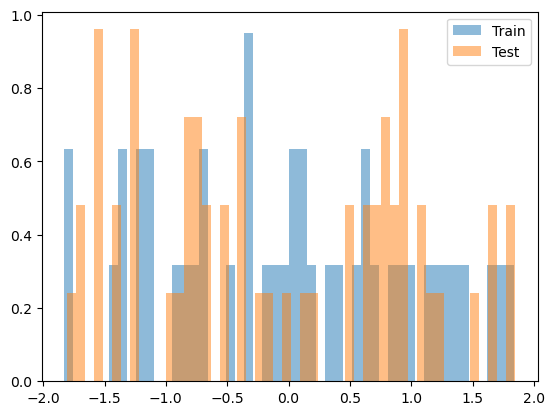

In [ ]:
gem.Y.plot_yields()

In [ ]:
ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
next(iter(ds))

(tensor(0.1281),
 tensor([1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.5000,
         1.0000, 0.5000]),
 tensor([[ 0.6586, -1.3527,  0.2799,  1.6154, -1.0831, -1.2287,  0.7447,  1.0475,
          -1.7051, -0.6592, -1.6990,  0.8659,  0.1971, -1.5005,  1.4679, -0.0057,
          -1.3124,  0.9911,  0.0959,  1.6687,  0.6416,  1.3909, -0.1510,  1.0113,
           1.3073, -1.7838,  1.4986, -0.6473,  0.9429, -0.3509, -1.2243, -0.0549,
           1.1983, -0.7537, -0.5440,  0.9003,  0.5778, -1.1093, -0.5868,  1.4705,
           1.7104,  0.6460, -1.9530,  0.3982, -0.6292, -0.8740,  1.7787, -0.7473,
          -1.0528, -0.6391]]))

In [ ]:
tr_ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
te_ds = GemDataset(gem.W.Te, gem.Y.Te, gem.SNP)

In [ ]:
tr_dl = DataLoader(tr_ds, batch_size=4)
te_dl = DataLoader(te_ds, batch_size=4)
dls = DataLoaders(tr_dl,te_dl)

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x


In [ ]:
from torcheval.metrics import MeanSquaredError,Mean, R2Score

In [ ]:
model = MLP(20,100, 1)
cbs = [TrainCB()]
learn = Learner(model, dls, F.mse_loss, lr=.25, cbs=cbs)
learn.fit(1)

/mnt/c/Users/cltng/OneDrive/Documents/Projects/hybridpredictmaize22/hybridpredictmaize22/GEMlearn.py:268: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  learn.loss = learn.loss_func(learn.preds.squeeze(), learn.batch[0])
